In [36]:
%load_ext autoreload
%autoreload 2
import torch 
import os
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
from src.utils.misc import snv
from torch import nn
from torch import optim
from src.net import CuiNet , DeepSpectraCNN, ResNet18_1D , ViT_1D
import matplotlib.pyplot as plt
from src.utils.misc import TrainerConfig
from src.utils import  test
from src.training.training import Trainer
import torch.utils.data as data_utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
cal1 = pd.read_csv('../data/dataset/Wheat_dt/DT_train-1.csv', header=None)
cal2 = pd.read_csv('../data/dataset/Wheat_dt/DT_train-2.csv', header=None)
cal3 = pd.read_csv('../data/dataset/Wheat_dt/DT_train-3.csv', header=None)
cal4 = pd.read_csv('../data/dataset/Wheat_dt/DT_train-4.csv', header=None)
cal5 = pd.read_csv('../data/dataset/Wheat_dt/DT_train-5.csv', header=None)
## validation
val1 = pd.read_csv('../data/dataset/Wheat_dt/DT_val-1.csv', header=None)
val2 = pd.read_csv('../data/dataset/Wheat_dt/DT_val-2.csv', header=None)
## test
pre1 = pd.read_csv('../data/dataset/Wheat_dt/DT_test-1.csv', header=None)
pre2 = pd.read_csv('../data/dataset/Wheat_dt/DT_test-2.csv', header=None)
pre3 = pd.read_csv('../data/dataset/Wheat_dt/DT_test-3.csv', header=None)


In [30]:
## Concatenate input variables, X
cal_features = np.concatenate((cal1.iloc[:, 0:-1],cal2.iloc[:, 0:-1],cal3.iloc[:, 0:-1],cal4.iloc[:, 0:-1],cal5.iloc[:, 0:-1]),axis=0)
val_features = np.concatenate((val1.iloc[:, 0:-1],val2.iloc[:, 0:-1]),axis = 0)
pre_features = np.concatenate((pre1.iloc[:, 0:-1],pre2.iloc[:, 0:-1],pre3.iloc[:, 0:-1]),axis = 0)

## Concatenate the target variable or lables, Y
cal_labels = np.concatenate((cal1.iloc[:, -1],cal2.iloc[:, -1],cal3.iloc[:, -1],cal4.iloc[:, -1],cal5.iloc[:, -1]),axis = 0)
val_labels = np.concatenate((val1.iloc[:, -1],val2.iloc[:, -1]),axis=0)
pre_labels = np.concatenate((pre1.iloc[:, -1],pre2.iloc[:, -1],pre3.iloc[:, -1]),axis = 0)

## Settings for the smooth derivatives using a Savitsky-Golay filter
w = 13 ## Sav.Gol window size
p = 2  ## Sav.Gol polynomial degree

## Perform data augmentation in the feature space by combining different types of typical chemometric spectral pre-processings
## [spectra, SNV, 1st Deriv., 2nd Deriv., 1st Deriv. SNV, 2nd Deriv. SNV]
x_cal = np.concatenate((cal_features, snv(cal_features),savgol_filter(cal_features, w, polyorder = p, deriv=1),\
                                savgol_filter(cal_features, w, polyorder = p, deriv=2),savgol_filter(snv(cal_features), w, polyorder = p, deriv=1),\
                                savgol_filter(snv(cal_features), w, polyorder = p, deriv=2)),axis = 1)
x_val = np.concatenate((val_features, snv(val_features),savgol_filter(val_features, w, polyorder = p, deriv=1),\
                                savgol_filter(val_features, w, polyorder = p, deriv=2),savgol_filter(snv(val_features), w, polyorder = p, deriv=1),\
                                savgol_filter(snv(val_features), w, polyorder = p, deriv=2)),axis =1)
x_test= np.concatenate((pre_features, snv(pre_features),savgol_filter(pre_features, w, polyorder = p, deriv=1),\
                                savgol_filter(pre_features, w, polyorder = p, deriv=2),savgol_filter(snv(pre_features), w, polyorder = p, deriv=1),\
                                savgol_filter(snv(pre_features), w, polyorder = p, deriv=2)),axis =1)


(72000, 200)


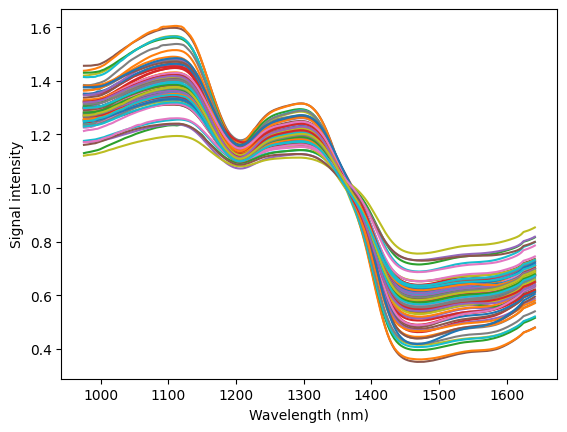

In [31]:
## Create wavelength x-scale by interpolating the range mentioned in the original wheat paper
delta_co = (1645-975)/200 # wavelenght step
# print(delta_co)
co=975+np.arange(200)*delta_co
print(cal_features.shape)
plt.plot(co, cal_features[:100,:].T)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Signal intensity')
plt.show()

y_cal = np.eye(30)[cal_labels]
y_val = np.eye(30)[val_labels]
y_test = np.eye(30)[pre_labels]

(72000, 200)
200
CuiNet(
  (dropout): ManualDropout()
  (conv1d): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=196, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=30, bias=True)
)
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNet_Wheat_best.pth
Epoch 1/100 | Train Loss: 0.2304 | Val Loss: 0.1523 | Val Mean Metrics: 0.0567
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNet_Wheat_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNet_Wheat_best.pth
Epoch 2/100 | Train Loss: 0.1460 | Val Loss: 0.1397 | Val Mean Metrics: 0.0860
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNet_Wheat_best.pth
Epoch 3/100 | Train Loss: 0.1372 | Val Loss: 0.1358 | Val Mean Metrics: 0.0900
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly

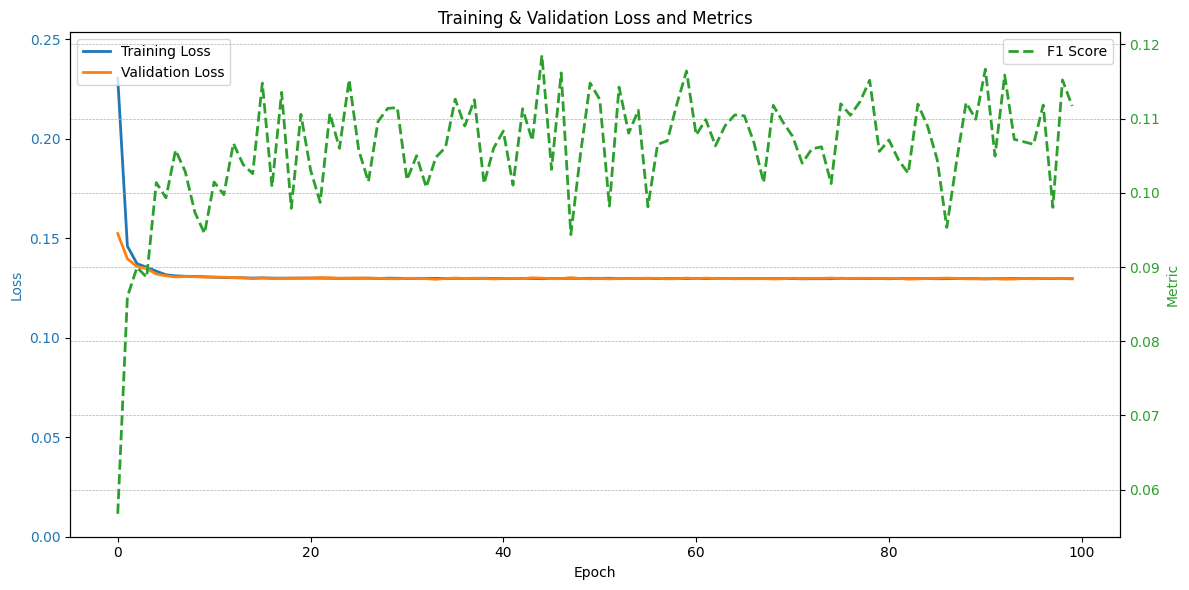

In [32]:
## Concatenate input variables, X
# calculate mean and std per column

mean = np.mean(cal_features, axis=0)
std = np.std(cal_features, axis=0)

model_name ="CuiNet_Wheat"
config = TrainerConfig(model_name=model_name)
config.update_config(batch_size=128,learning_rate=0.001,num_epochs=100,save_model=True,classification=True,max_loss_plot=20)
# Convert np.array to Dataloader 

cal = data_utils.TensorDataset(torch.Tensor(cal_features), torch.Tensor(y_cal))
cal_loader = data_utils.DataLoader(cal, batch_size=config.batch_size, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(val_features), torch.Tensor(y_val))
val_loader = data_utils.DataLoader(val, batch_size=config.batch_size, shuffle=True)

test_dt = data_utils.TensorDataset(torch.Tensor(pre_features), torch.Tensor(y_test))
test_loader = data_utils.DataLoader(test_dt, batch_size=config.batch_size, shuffle=True)


spec_dims = cal_features.shape[-1]
print(cal_features.shape)
print(spec_dims)


model = CuiNet(spec_dims, mean = mean,std = std, out_dims=30)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=0.003/2)
criterion = nn.BCEWithLogitsLoss(reduction='mean')
criterion_test = nn.BCEWithLogitsLoss(reduction='mean')
print(model)

trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_loader=cal_loader, val_loader=val_loader, config=config)
train_losses, val_losses,val_r2_scores, final_path = trainer.train()


In [33]:
test(model,final_path,test_loader,config)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1054
           1       0.18      0.00      0.00      1431
           2       1.00      0.00      0.00      1332
           3       1.00      0.00      0.00      1335
           4       0.07      0.06      0.06      1259
           5       0.10      0.51      0.17      1277
           6       0.12      0.01      0.01      1355
           7       1.00      0.00      0.00      1353
           8       1.00      0.00      0.00      1360
           9       0.03      0.00      0.00      1361
          10       1.00      0.00      0.00      1283
          11       1.00      0.00      0.00      1273
          12       1.00      0.00      0.00      1280
          13       0.03      0.00      0.00      1134
          14       0.14      0.28      0.19      1356
          15       0.12      0.65      0.20      1356
          16       0.16      0.63      0.25      1353
          17       1.00    

(72000, 200)
200
ResNet1D(
  (conv1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): ResidualBlock1D(
      (conv1): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock1D(
      (conv1): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm

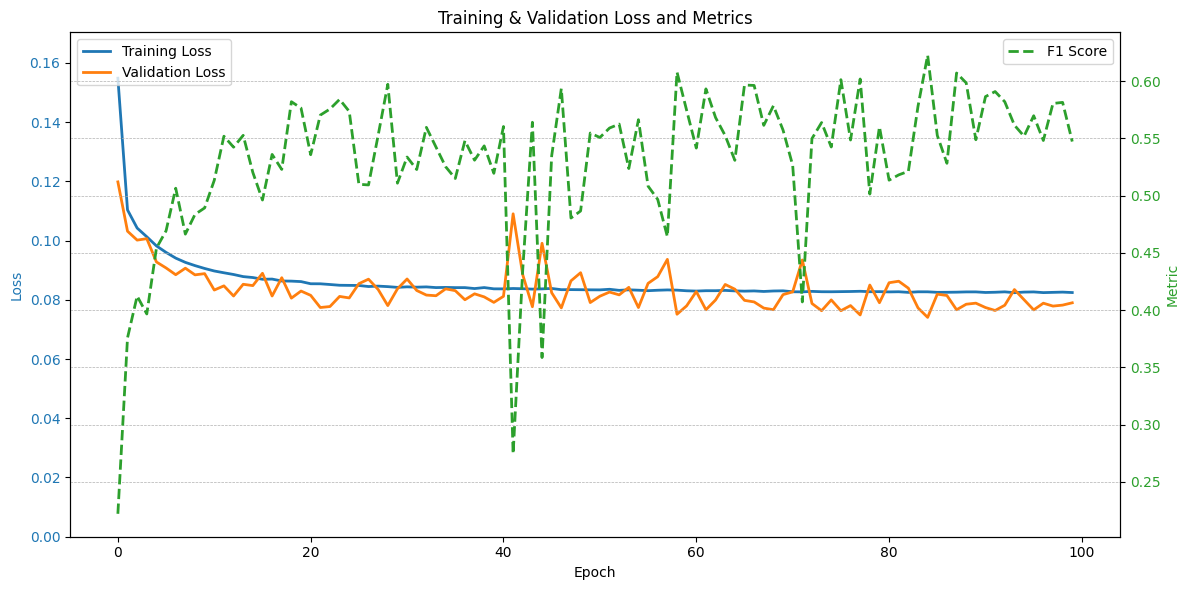

In [34]:
model_name ="_ResNET18_Wheat_"



config = TrainerConfig(model_name=model_name)
config.update_config(batch_size=128,learning_rate=0.001,num_epochs=100,save_model=True,classification=True,max_loss_plot=20)
# Convert np.array to Dataloader

cal = data_utils.TensorDataset(torch.Tensor(cal_features), torch.Tensor(y_cal))
cal_loader = data_utils.DataLoader(cal, batch_size=config.batch_size, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(val_features), torch.Tensor(y_val))
val_loader = data_utils.DataLoader(val, batch_size=config.batch_size, shuffle=True)

test_dt = data_utils.TensorDataset(torch.Tensor(pre_features), torch.Tensor(y_test))
test_loader = data_utils.DataLoader(test_dt, batch_size=config.batch_size, shuffle=True)


spec_dims = cal_features.shape[-1]
print(cal_features.shape)
print(spec_dims)


model = ResNet18_1D(mean = mean,std = std, out_dims=30)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=0.003/2)
criterion = nn.BCEWithLogitsLoss(reduction='mean')
criterion_test = nn.BCEWithLogitsLoss(reduction='mean')
print(model)

trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_loader=cal_loader, val_loader=val_loader, config=config)
train_losses, val_losses,val_r2_scores, final_path = trainer.train()

In [35]:
test(model,final_path,test_loader,config)

              precision    recall  f1-score   support

           0       0.69      0.74      0.71      1054
           1       0.57      0.90      0.70      1431
           2       0.73      0.40      0.52      1332
           3       0.77      0.20      0.32      1335
           4       0.49      0.27      0.34      1259
           5       0.52      0.27      0.36      1277
           6       0.46      0.84      0.59      1355
           7       0.46      0.87      0.61      1353
           8       0.51      0.17      0.26      1360
           9       0.74      0.78      0.76      1361
          10       0.70      0.36      0.47      1283
          11       0.44      0.87      0.58      1273
          12       0.63      0.61      0.62      1280
          13       0.66      0.56      0.61      1134
          14       0.64      0.63      0.64      1356
          15       0.64      0.64      0.64      1356
          16       0.86      0.79      0.82      1353
          17       0.76    